In [2]:
import datashader as ds
import datashader.transfer_functions as tf
import datashader.glyphs
from datashader import reductions
from datashader.core import bypixel
from datashader.utils import lnglat_to_meters as webm, export_image
from datashader.colors import colormap_select, Greys9, viridis, inferno
import copy
import math


from pyproj import Proj, transform
import numpy as np
import pandas as pd
import urllib
import json
import datetime
import colorlover as cl

import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

from shapely.geometry import Point, Polygon, shape
# In order to get shapley, you'll need to run [pip install shapely.geometry] from your terminal
from plotly.graph_objs import *

from functools import partial, reduce

from IPython.display import GeoJSON

For module 2 we'll be looking at techniques for dealing with big data. In particular binning strategies and the datashader library (which possibly proves we'll never need to bin large data for visualization ever again.)

To demonstrate these concepts we'll be looking at the PLUTO dataset put out by New York City's department of city planning. PLUTO contains data about every tax lot in New York City.

PLUTO data can be downloaded from [here](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page). Unzip them to the same directory as this notebook, and you should be able to read them in using this (or very similar) code. Also take note of the data dictionary, it'll come in handy for this assignment.

In [6]:
bk = pd.read_csv('PLUTO17v1.1/BK2017V11.csv', low_memory=False)
bx = pd.read_csv('PLUTO17v1.1/BX2017V11.csv', low_memory=False)
mn = pd.read_csv('PLUTO17v1.1/MN2017V11.csv', low_memory=False)
qn = pd.read_csv('PLUTO17v1.1/QN2017V11.csv', low_memory=False)
si = pd.read_csv('PLUTO17v1.1/SI2017V11.csv', low_memory=False)

ny = pd.concat([bk, bx, mn, qn, si], ignore_index=True)

# Getting rid of some outliers
ny = ny[(ny['YearBuilt'] > 1850) & (ny['YearBuilt'] < 2020) & (ny['NumFloors'] != 0)]

I'll also do some prep for the geographic component of this data, which we'll be relying on for datashader.

You're not required to know how I'm retrieving the lattitude and longitude here, but for those interested: this dataset uses a flat x-y projection (assuming for a small enough area that the world is flat for easier calculations), and this needs to be projected back to traditional lattitude and longitude.

In [7]:


wgs84 = Proj("+proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs")
nyli = Proj("+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs")
ny['XCoord'] = 0.3048*ny['XCoord']
ny['YCoord'] = 0.3048*ny['YCoord']
ny['lon'], ny['lat'] = transform(nyli, wgs84, ny['XCoord'].values, ny['YCoord'].values)

ny = ny[(ny['lon'] < -60) & (ny['lon'] > -100) & (ny['lat'] < 60) & (ny['lat'] > 20)]

#Defining some helper functions for DataShader
background = "black"
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

## Part 1: Binning and Aggregation

Binning is a common strategy for visualizing large datasets. Binning is inherent to a few types of visualizations, such as histograms and [2D histograms](https://plot.ly/python/2D-Histogram/) (also check out their close relatives: [2D density plots](https://plot.ly/python/2d-density-plots/) and the more general form: [heatmaps](https://plot.ly/python/heatmaps/).

While these visualization types explicitly include binning, any type of visualization used with aggregated data can be looked at in the same way. For example, lets say we wanted to look at building construction over time. This would be best viewed as a line graph, but we can still think of our results as being binned by year:

In [8]:
trace = go.Scatter(
    # I'm choosing BBL here because I know it's a unique key.
    x = ny.groupby('YearBuilt').count()['BBL'].index,
    y = ny.groupby('YearBuilt').count()['BBL']
)

layout = go.Layout(
    xaxis = dict(title = 'Year Built'),
    yaxis = dict(title = 'Number of Lots Built')
)

fig = go.Figure(data = [trace], layout = layout)

py.iplot(fig, filename = 'ny-year-built')

Something looks off... You're going to have to deal with this imperfect data to answer this first question. 

But first: some notes on pandas. Pandas dataframes are a different beast than R dataframes, here are some tips to help you get up to speed:

---

Hello all, here are some pandas tips to help you guys through this homework:

[Indexing and Selecting](https://pandas.pydata.org/pandas-docs/stable/indexing.html): .loc and .iloc are the analogs for base R subsetting, or filter() in dplyr

[Group By](https://pandas.pydata.org/pandas-docs/stable/groupby.html):  This is the pandas analog to group_by() and the appended function the analog to summarize(). Try out a few examples of this, and display the results in Jupyter. Take note of what's happening to the indexes, you'll notice that they'll become hierarchical. I personally find this more of a burden than a help, and this sort of hierarchical indexing leads to a fundamentally different experience compared to R dataframes. Once you perform an aggregation, try running the resulting hierarchical datafrome through a [reset_index()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html).

[Reset_index](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html): I personally find the hierarchical indexes more of a burden than a help, and this sort of hierarchical indexing leads to a fundamentally different experience compared to R dataframes. reset_index() is a way of restoring a dataframe to a flatter index style. Grouping is where you'll notice it the most, but it's also useful when you filter data, and in a few other split-apply-combine workflows. With pandas indexes are more meaningful, so use this if you start getting unexpected results.

Indexes are more important in Pandas than in R. If you delve deeper into the using python for data science, you'll begin to see the benefits in many places (despite the personal gripes I highlighted above.) One place these indexes come in handy is with time series data. The pandas docs have a [huge section](http://pandas.pydata.org/pandas-docs/stable/timeseries.html) on datetime indexing. In particular, check out [resample](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html), which provides time series specific aggregation.

[Merging, joining, and concatenation](https://pandas.pydata.org/pandas-docs/stable/merging.html): There's some overlap between these different types of merges, so use this as your guide. Concat is a single function that replaces cbind and rbind in R, and the results are driven by the indexes. Read through these examples to get a feel on how these are performed, but you will have to manage your indexes when you're using these functions. Merges are fairly similar to merges in R, similarly mapping to SQL joins.

Apply: This is explained in the "group by" section linked above. These are your analogs to the plyr library in R. Take note of the lambda syntax used here, these are anonymous functions in python. Rather than predefining a custom function, you can just define it inline using lambda.

Browse through the other sections for some other specifics, in particular reshaping and categorical data (pandas' answer to factors.) Pandas can take a while to get used to, but it is a pretty strong framework that makes more advanced functions easier once you get used to it. Rolling functions for example follow logically from the apply workflow (and led to the best google results ever when I first tried to find this out and googled "pandas rolling")

Google Wes Mckinney's book "Python for Data Analysis," which is a cookbook style intro to pandas. It's an O'Reilly book that should be pretty available out there.

---

### Question

After a few building collapses, the City of New York is going to begin investigating older buildings for safety. The city is particularly worried about buildings that were unusually tall when they were built, since best-practices for safety hadn’t yet been determined. Create a graph that shows how many buildings of a certain number of floors were built in each year (note: you may want to use a log scale for the number of buildings). Find a strategy to bin buildings (It should be clear 20-29-story buildings, 30-39-story buildings, and 40-49-story buildings were first built in large numbers, but does it make sense to continue in this way as you get taller?)

In [9]:

import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [10]:
# Start your answer here, inserting more cells as you go along


# Starting by taking the years from 1850  till date (2018)
# Copying only relevant columns under study

nycheck = ny[(ny['YearBuilt'] > 1850) & (ny['YearBuilt'] < 2018) & (ny['NumFloors'] != 0)]
nycheck = nycheck[['YearBuilt', 'NumFloors']].copy()



# Since some of the floors have a mezanine floor, it is counted as one and hence rounded up.
nycheck['NumFloors'] = np.ceil(nycheck['NumFloors'])

nycheck_yb_nf = pd.DataFrame()

# Grouping the data by 'YearBuilt' and by ' NumFloors'
nycheck_yb_nf_grp = nycheck.groupby(['YearBuilt', 'NumFloors'])

# Getting the count of NumFloors whih imples number of buildings for that many floors
# (since there would be similar floored buildings built in same year on different lots i.e.BBL)

nycheck_yb_nf['NumBuild'] = nycheck_yb_nf_grp['NumFloors'].count()

# Reseting index to columns 
nycheck_yb_nf = nycheck_yb_nf.reset_index(level = 'NumFloors')   
nycheck_yb_nf = nycheck_yb_nf.reset_index(level = 'YearBuilt')    

# Checking the first few rows of dataframe formed thus.
nycheck_yb_nf.iloc[:20,:3]


,YearBuilt,NumFloors,NumBuild
0,1851,3.0,3
1,1851,4.0,4
2,1851,5.0,1
3,1852,2.0,2
4,1852,3.0,7
5,1852,4.0,2
6,1852,5.0,3
7,1853,2.0,1
8,1853,3.0,5
9,1853,4.0,3


In [12]:
# Function to round up to next tens, hence 22 will be rounded to 30, 11 to 20 and likewise.

def roundup(x):
    return int(math.ceil(x / 10.0)) * 10

# Applying the roundup functions to the floor numbers to create slabs further.
nycheck_yb_nf['floor_rounded'] = nycheck_yb_nf['NumFloors'].apply(lambda x: roundup(x))


nycheck_yb_nf.iloc[:20,:5]


,YearBuilt,NumFloors,NumBuild,floor_rounded
0,1851,3.0,3,10
1,1851,4.0,4,10
2,1851,5.0,1,10
3,1852,2.0,2,10
4,1852,3.0,7,10
5,1852,4.0,2,10
6,1852,5.0,3,10
7,1853,2.0,1,10
8,1853,3.0,5,10
9,1853,4.0,3,10


In [13]:
floorslab_dict = {10 : '10 Under ',
                  20 : 'Between 11 and 20',
                  30 : 'Between 21 and 30',
                  40 : 'Between 31 and 40',
                  50 : 'Between 41 and 50',
                  60 : 'Between 51 and 60',
                  70 : 'Between 61 and 70',
                  80 : 'Between 71 and 80',
                  90 : 'Between 81 and 90',
                  100 : 'Between 91 to 100',
                  110 : 'Between 101 and 110',
                  120 : 'Between 111 and 120',
                  130 : 'Between 121 and 130',
                  140 : 'Between 131 and 140'}

# The floors slabs are categorized.
nycheck_yb_nf['floor_slab'] = nycheck_yb_nf['floor_rounded'].map(floorslab_dict)
nycheck_yb_nf.iloc[:20,:5]





,YearBuilt,NumFloors,NumBuild,floor_rounded,floor_slab
0,1851,3.0,3,10,10 Under
1,1851,4.0,4,10,10 Under
2,1851,5.0,1,10,10 Under
3,1852,2.0,2,10,10 Under
4,1852,3.0,7,10,10 Under
5,1852,4.0,2,10,10 Under
6,1852,5.0,3,10,10 Under
7,1853,2.0,1,10,10 Under
8,1853,3.0,5,10,10 Under
9,1853,4.0,3,10,10 Under


In [14]:
nycheck_ybin_fbin = nycheck_yb_nf[['YearBuilt', 'NumBuild','floor_slab']].copy()

ny_ybin_fbin = pd.DataFrame()
nycheck_ybin_fbin

# Grouping the data by 'YearBuilt' and by ' floor_slab'
ny_ybin_fbin_grp = nycheck_ybin_fbin.groupby(['YearBuilt', 'floor_slab'])
ny_ybin_fbin = ny_ybin_fbin_grp.sum()

# Reseting index to columns 
ny_ybin_fbin = ny_ybin_fbin.reset_index(level = 'floor_slab')   
ny_ybin_fbin = ny_ybin_fbin.reset_index(level = 'YearBuilt')    

ny_ybin_fbin.iloc[:20,:5]


,YearBuilt,floor_slab,NumBuild
0,1851,10 Under,8
1,1852,10 Under,14
2,1853,10 Under,11
3,1853,Between 11 and 20,1
4,1854,10 Under,6
5,1855,10 Under,13
6,1856,10 Under,11
7,1857,10 Under,8
8,1858,10 Under,7
9,1859,10 Under,9


In [15]:
# Pivoted for display purpose.     

pt = ny_ybin_fbin.pivot(values='NumBuild', index='YearBuilt',columns='floor_slab')

pt.columns.name=None
pt.reset_index(level="YearBuilt")
pt.head(10)

,10 Under,Between 101 and 110,Between 11 and 20,Between 111 and 120,Between 21 and 30,Between 31 and 40,Between 41 and 50,Between 51 and 60,Between 61 and 70,Between 71 and 80,Between 81 and 90
YearBuilt,,,,,,,,,,,
1851,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1852,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1853,11.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1854,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1855,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1856,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1857,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1858,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1859,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
# A 3D scatterplot to display the building constructions and its floor rise by the year.
# The color scheme displays less / more number of buildings . The number of buildings itself is log scaled.


trace1 = Scatter3d(
    x=ny_ybin_fbin['YearBuilt'],
    y=np.log(ny_ybin_fbin['NumBuild']),
    z=ny_ybin_fbin['floor_slab'],
    text=ny_ybin_fbin['NumBuild'],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        sizeref=750,
        color = np.log(ny_ybin_fbin['NumBuild']),
        colorscale = 'Viridis',
        colorbar = dict(title = 'Building Count (Log Scale)',
                       tickvals = [0.1,6,11],
                       ticktext = ['1','600','90,000']),
        line=dict(color='rgb(140, 140, 170)')
    )
)

data=[trace1]
layout=dict(height=800, width=800,yaxis=dict(type='category', title='Number of Floors'), title='Examining Building Constructions /  Floor Rises Over Period 1850 - 2018')

#layout = go.Layout(
#    yaxis=dict(type='log', title='Number of Buildings (Log Scale)')
#)
fig=dict(data=data, layout=layout)
plotly.offline.iplot(fig)


We observe that in the early 1900 very few buildings were of a height of 61- 70 floors ex in 1910 and 1913. Such seem to be against the norm back then when most of the buildings were under 10 and few in the 11 - 20 / 21-30 slabs.
Such could be called unusually tall for that period and could be considered be the city authorities as unsafe / not meeting the possible standards then.

## Part 2: Datashader

Datashader is a library from Anaconda that does away with the need for binning data. It takes in all of your datapoints, and based on the canvas and range returns a pixel-by-pixel calculations to come up with the best representation of the data. In short, this completely eliminates the need for binning your data.

As an example, lets continue with our question above and look at a 2D histogram of YearBuilt vs NumFloors:

In [22]:
yearbins = 200
floorbins = 200

yearBuiltCut = pd.cut(ny['YearBuilt'], np.linspace(ny['YearBuilt'].min(), ny['YearBuilt'].max(), yearbins))
numFloorsCut = pd.cut(ny['NumFloors'], np.logspace(1, np.log(ny['NumFloors'].max()), floorbins))

xlabels = np.floor(np.linspace(ny['YearBuilt'].min(), ny['YearBuilt'].max(), yearbins))
ylabels = np.floor(np.logspace(1, np.log(ny['NumFloors'].max()), floorbins))

data = [
    go.Heatmap(z = ny.groupby([numFloorsCut, yearBuiltCut])['BBL'].count().unstack().fillna(0).values,
              colorscale = 'Greens', x = xlabels, y = ylabels)
]

py.iplot(data, filename = 'datashader-2d-hist')

This shows us the distribution, but it's subject to some biases discussed in the Anaconda notebook [Plotting Perils](https://anaconda.org/jbednar/plotting_pitfalls/notebook). 

Here is what the same plot would look like in datashader:



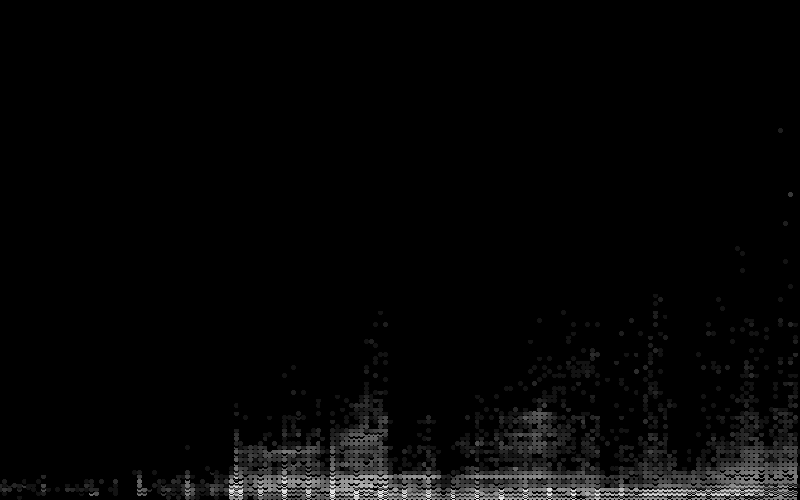

In [23]:
cvs = ds.Canvas(800, 500, x_range = (ny['YearBuilt'].min(), ny['YearBuilt'].max()), 
                                y_range = (ny['NumFloors'].min(), ny['NumFloors'].max()))
agg = cvs.points(ny, 'YearBuilt', 'NumFloors')
view = tf.shade(agg, cmap = cm(Greys9), how='log')
export(tf.spread(view, px=2), 'yearvsnumfloors')

That's technically just a scatterplot, but the points are smartly placed and colored to mimic what one gets in a heatmap. Based on the pixel size, it will either display individual points, or will color the points of denser regions.

Datashader really shines when looking at geographic information. Here are the latitudes and longitudes of our dataset plotted out, giving us a map of the city colored by density of structures:

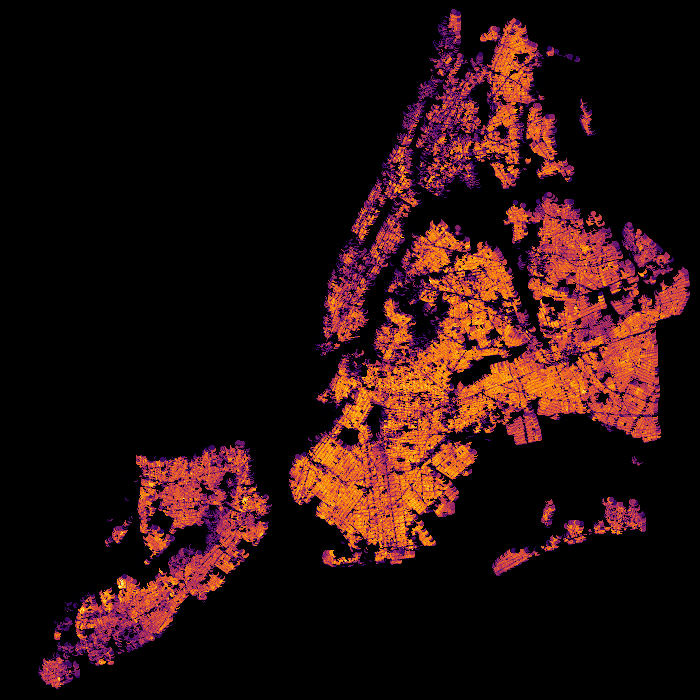

In [24]:
NewYorkCity   = (( -74.29,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'lon', 'lat')
view = tf.shade(agg, cmap = cm(inferno), how='log')
export(tf.spread(view, px=2), 'firery')

Interestingly, since we're looking at structures, the large buildings of Manhattan show up as less dense on the map. The densest areas measured by number of lots would be single or multi family townhomes.

Unfortunately, Datashader doesn't have the best documentation. Browse through the examples from their [github repo](https://github.com/bokeh/datashader/tree/master/examples). I would focus on the [visualization pipeline](https://anaconda.org/jbednar/pipeline/notebook) and the [US Census](https://anaconda.org/jbednar/census/notebook) Example for the question below. Feel free to use my samples as templates as well when you work on this problem.

### Question

You work for a real estate developer and are researching underbuilt areas of the city. After looking in the [Pluto data dictionary](https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?v=17v1_1), you've discovered that all tax assessments consist of two parts: The assessment of the land and assessment of the structure. You reason that there should be a correlation between these two values: more valuable land will have more valuable structures on them (more valuable in this case refers not just to a mansion vs a bungalow, but an apartment tower vs a single family home). Deviations from the norm could represent underbuilt or overbuilt areas of the city. You also recently read a really cool blog post about [bivariate choropleth maps](http://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/), and think the technique could be used for this problem.

Datashader is really cool, but it's not that great at labeling your visualization. Don't worry about providing a legend, but provide a quick explanation as to which areas of the city are overbuilt, which areas are underbuilt, and which areas are built in a way that's properly correlated with their land value.

Per the BiVariate Chloropeth Map, the assessment types of AssessTot and AssessLand are further divided into the percentile classes internally with color scheme (Viridis).
This divided into A1, A2, A3, B1, B2, B3, C1, C2, C3 categories with C2 being represented by the most dense  color (Dark purple as seen in the map) standing for overbuilt  and A1 as the lightest shade ( yellow as seen in map) that represent underbuilt areas of NYC.


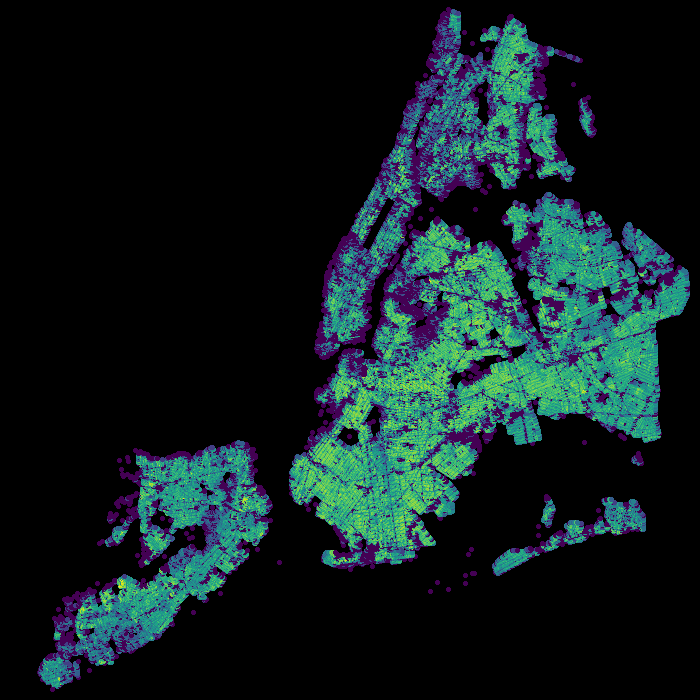

In [91]:
nyassess = ny[['AssessTot', 'AssessLand','lon','lat']].copy()
nyassess['AssessStructure'] = ny['AssessTot'] - ny['AssessLand']

NewYorkCity   = (( -74.29,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)


assess_structure = cvs.points(nyassess, 'lon', 'lat', ds.count('AssessStructure'))
assess_land = cvs.points(nyassess, 'lon', 'lat', ds.count('AssessLand'))
viewstruct = tf.shade(assess_structure, cmap = cm(viridis), how='log')
viewland = tf.shade(assess_land, cmap = cm(viridis), how='log')

view = tf.stack(viewland,viewstruct)
view
export(tf.spread(view, px=2), 'cloropleth')
